In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import igraph as ig
import random
from matplotlib.lines import Line2D

mpl.rcParams['figure.dpi'] = 300
L = 16
sequences_int = range(2**L)

def reachable(s, L):
    return [(s | 2**ii) for ii in range(L) if (s | 2**ii) > s]
mutation_names = ['N26D','S29R','Y35N','Y48C','D49Y','V98I','G31D','Y33H','M34I','H35N','N52H','G57D','L83V','S84N','R85G','R87K']


## Read data into graph

In [3]:
df = pd.read_csv(f"../Kd_Inference/results_CH65/Kd_processed/20221008_CH65_MA90_browser.tsv",
                 dtype={"geno":"str"}, sep="\t")


reps = set([a.split("_")[-1] 
            for a in df.keys() 
            if a.startswith("mean_log10PE")])
concs = set([int(a.split("_")[1][7:])
            for a in df.keys() 
            if a.startswith("mean_log10PE")])            
for aa in reps:
    for ii in concs:
        df = df.rename({f"mean_log10PE{ii}_{aa}": f"mean_log10PE{ii}_{aa}_MA90",
                   f"std_log10PE{ii}_{aa}":f"std_log10PE{ii}_{aa}_MA90"}, axis=1) 

for ab in ['SI06', 'G189E']:
    dft = pd.read_csv(f"../Kd_Inference/results_CH65/Kd_processed/20221008_CH65_{ab}_browser.tsv",
                 dtype={"geno":"str"}, sep="\t").set_index("geno")
    df[f"log10Kd_{ab}"] = df.geno.map(dft.log10Kd)
    df[f"err_log10Kd_{ab}"] = df.geno.map(dft.err_log10Kd)
    repscon = set([(a.split("_")[-1], int(a.split("_")[1][7:]))
                for a in dft.keys() 
                if a.startswith("mean_log10PE")])
    for aa, ii in repscon:
            df[f"mean_log10PE{ii}_{aa}_{ab}"] = df.geno.map(dft[f"mean_log10PE{ii}_{aa}"])
            df[f"std_log10PE{ii}_{aa}_{ab}"] = df.geno.map(dft[f"std_log10PE{ii}_{aa}"])
            


df["variant_int"] = df.geno.apply(lambda x: int(x, 2))

df = df.set_index("variant_int").reindex(range(0, 2**L)).reset_index()
df["geno"] = df.variant_int.apply(lambda x: f"{x:0{L}b}")
sequences_int = range(0,2**L)
for ii in range(L):
    df[f"mutation_{ii+1}"] = df.geno.str[ii] == '1'
    
df["expression_norm_b"] = df['Mean fluorescence expression_b']/df['Mean fluorescence expression_b'].mean()
df["expression_norm_a"] = df['Mean fluorescence expression_a']/df['Mean fluorescence expression_a'].mean()
df["expression_norm"] = (df["expression_norm_b"])

In [4]:
# read data into graph


fitnesses = {}
fitnesses["MA90"] = (df.set_index("variant_int")["log10Kd"]).to_dict()
for ab in ['SI06', 'G189E']:
    fitnesses[ab] = (df.set_index("variant_int")["log10Kd"]).to_dict()
    
g = ig.Graph()
vertices = [s for s in sequences_int if ~np.isnan(fitnesses["MA90"][s])]
g.add_vertices([str(s) for s in vertices])
g.add_edges([(str(s),str(t)) for s in vertices for t in reachable(s, L) if t in vertices])


#### weight choices ####
# high weight means very close nodes on the graph.
weight_strength = 30000
min_difference = 1e-5
g.es["weight"] = [weight_strength/(min_difference 
                                   + np.abs(fitnesses["MA90"][t] - fitnesses["MA90"][s]) ) # weight
                            for s in vertices
                  for t in reachable(s, L) if t in vertices]
########################

g.vs["endpoints"] = [(s == 0 or s == len(sequences_int)-1) for s in sequences_int]

## Draw layout

In [5]:
# draw the layout

# generate seed
random.seed(42) 
seed = np.empty((len(vertices),2))
for i in range(len(vertices)):
    xcoord = random.uniform(-100,100)
    ycoord = random.uniform(-100,100)
    seed[i,:] = [xcoord,ycoord]
    
# create layout
layout = g.layout_drl(weights='weight',seed=seed)

# update df
coord =  np.array(layout.coords)
#print(coord)
xcoord = {vertices[i]:-1.0*coord[i, 1] for i in range(len(vertices))}
ycoord = {vertices[i]:coord[i, 0] for i in range(len(vertices))}
df["fdl_x"] = df.variant_int.map(xcoord)
df["fdl_y"] = df.variant_int.map(ycoord)


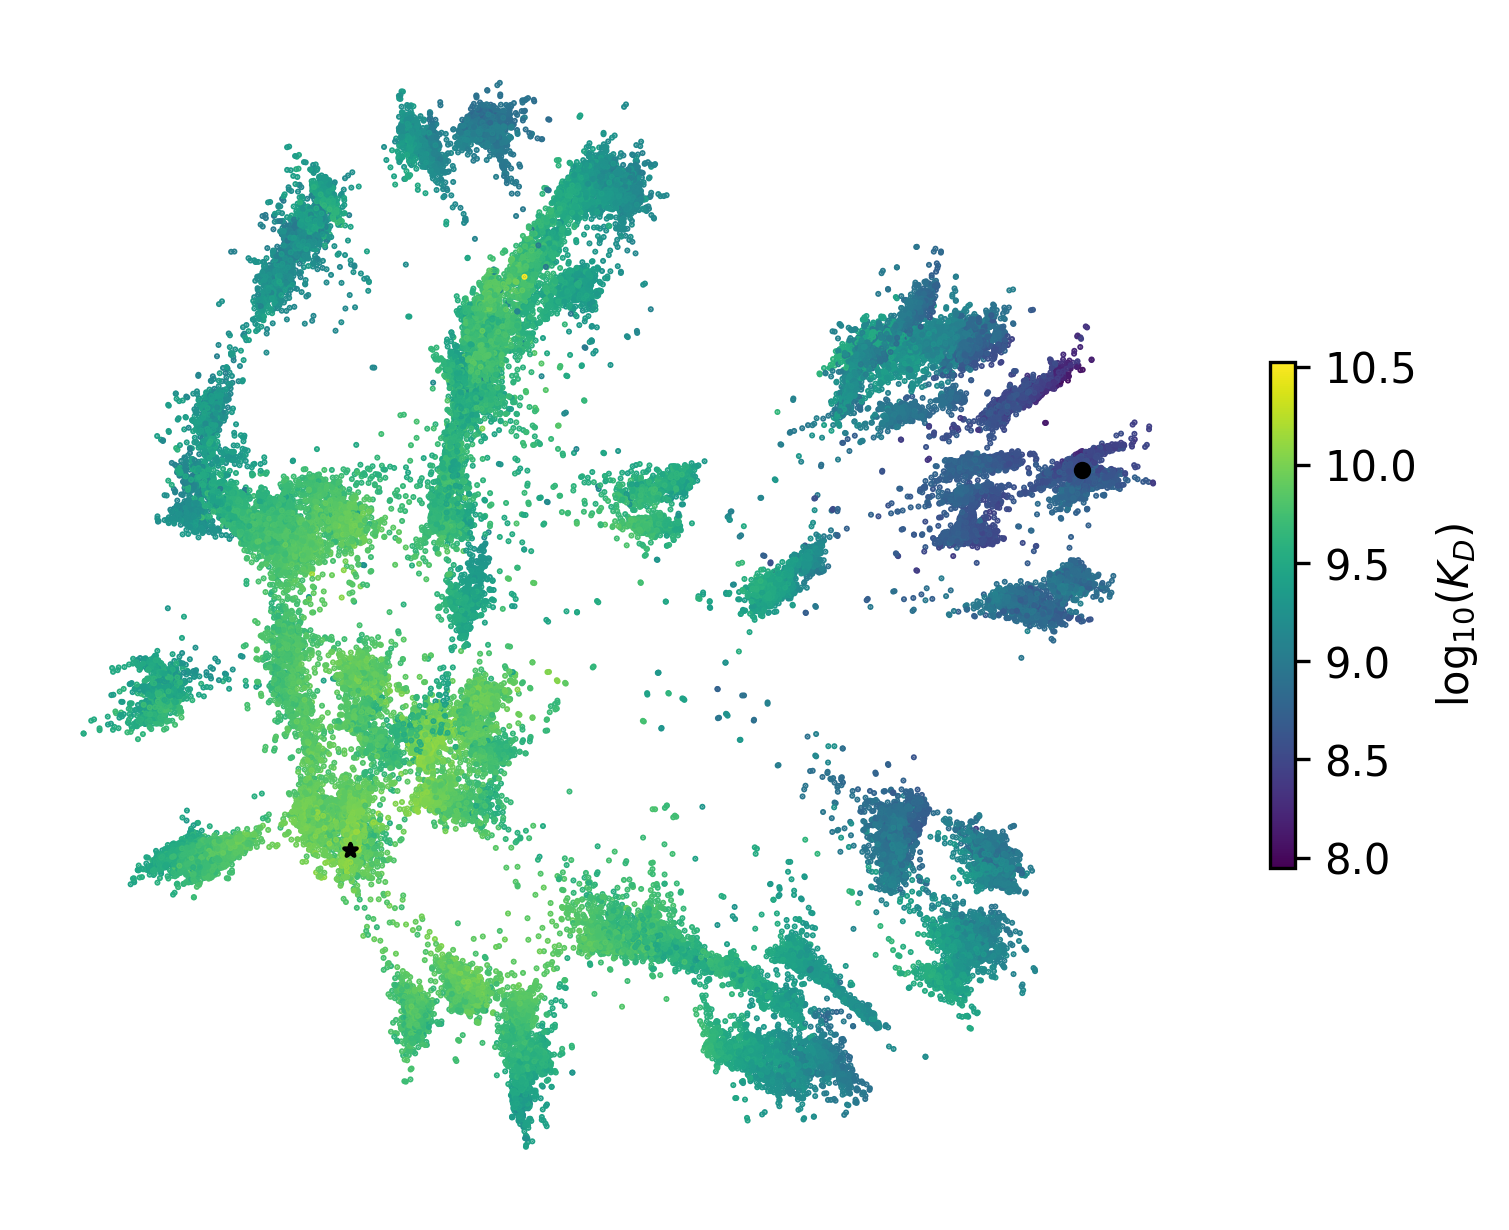

In [6]:
fig, ax = plt.subplots(figsize=(5,5))
sc = ax.scatter(x=df.fdl_x, y=df.fdl_y,
           s=0.2, c=df.log10Kd, alpha=1)
plt.colorbar(sc,fraction=0.02,label=r"$\log_{10}(K_D)$")

ax.scatter(x=df[df.geno == "0"*L].fdl_x, y=df[df.geno == "0"*L].fdl_y,
           s=10, c='black', alpha=1, marker="o")
ax.scatter(x=df[df.geno == "1"*L].fdl_x, y=df[df.geno == "1"*L].fdl_y,
           s=10, c="black", alpha=1, marker="*")
ax.set_aspect('equal')
ax.set_axis_off()
plt.tight_layout()
plt.show()

## Generate files for data browser

In [7]:
## Prepare the csv for the data browser
df["variant"] = df.geno
df["MA90_log10Kd"] = -df.log10Kd
df["MA90_stelog10Kd"] = df.err_log10Kd
# not actually a Kd but the browser is dumb
df["Expression_log10Kd"] = df.expression_norm
df["Expression_stelog10Kd"] = np.sqrt((df.expression_norm_a - df.expression_norm)**2 + 
                                      (df.expression_norm_b - df.expression_norm)**2)/np.sqrt(2)


for ab in ['SI06', 'G189E']:
    df[f"{ab}_log10Kd"] = -df[f"log10Kd_{ab}"]
    df[f"{ab}_stelog10Kd"] = df[f"err_log10Kd_{ab}"]

solutes = ['MA90', 'SI06', 'G189E']
for ab in solutes:
    for ii in range(L):
        Kds = df.set_index("geno")[f"{ab}_log10Kd"].to_dict()
        df[f"{ab}_{ii}_deltaKd"] = df.geno.apply(lambda x: (x,x[:ii]+'1'+x[ii+1:]) if x[ii] == '0' else "null")
        df[f"{ab}_{ii}_deltaKd"] = df[f"{ab}_{ii}_deltaKd"].apply(lambda x: Kds[x[1]] - Kds[x[0]]
                                                                  if x != "null" else "null")

df[["variant"] +
    [f"{ab}_log10Kd" for ab in solutes] + [f"{ab}_stelog10Kd" for ab in solutes]
    + ["Expression_log10Kd", "Expression_stelog10Kd",
    "fdl_x", "fdl_y"] + 
   [f"{ab}_{ii}_deltaKd" for ii in range(L) for ab in solutes]
  ].to_csv("data/CH65.csv")


## Prepare the mean bin pyarrow for the data browser
for ab in solutes:
    dfmb = df.copy()
    repscon = set([(a.split("_")[-2], int(a.split("_")[1][7:]))
                for a in dfmb.keys() 
                if a.startswith("mean_log10PE") and a.endswith(ab)])
    cols = ["variant", f"{ab}_log10Kd"]
    for aa, ii in repscon:
        dfmb[f"c{ii}_{aa}"] = dfmb[f"mean_log10PE{ii}_{aa}_{ab}"]
        dfmb[f"e{ii}_{aa}"] = dfmb[f"std_log10PE{ii}_{aa}_{ab}"]
        cols += [f"c{ii}_{aa}", f"e{ii}_{aa}"]
    dfmb.dropna(subset=[f"{ab}_log10Kd"]).reset_index()[cols].to_feather(
        f"data/{ab}.arrow", compression="uncompressed")